# Q1

## 1. Load a small open‐source object detection dataset

In [ ]:
# Setup
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import cv2
import os
import pickle
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from torch.utils.data import DataLoader
from collections import OrderedDict
import glob
import shutil
from matplotlib import patches

### Load COCO Minitrain Dataset 10k using Hugging Face (*Failed*)

In [ ]:
!pip install datasets # Install Hugging Face datasets library if not already installed

In [ ]:
from datasets import load_dataset

# Load the 10k images dataset "coco_minitrain_10k.zip" from the hugging face dataset "bryanbocao/coco_minitrain"
# https://huggingface.co/datasets/bryanbocao/coco_minitrain
# load_dataset automatically extracts zip folders
dataset = load_dataset("bryanbocao/coco_minitrain", data_files="coco_minitrain_10k.zip")

In [ ]:
# Get the training split
train_data = dataset['train']

In [ ]:
# View the first few image labels
display(train_data[0:4])

*Notice that all of the labels are for some reason 0, I think there is something with the way I am trying to extract this hugging face dataset or something wrong with how the dataset is stored on hugging face.*

### Load COCO Minitrain 10k Dataset by mounting Google Drive (*Failed*)

*When I downloaded the dataset from hugging face to my local machine I noticed that the labels were indeed there and not 0 like before. So, I decided to instead upload the zipped folder of the dataset to Google Drive, mount the drive, then unzip it in this notebook environment.*

In [ ]:
# Mount Google Drive to Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

*At this point I had to stop, because when trying to upload the zipped file to Google Drive, it said the estimated amount of time would be 3 hours, and it would probably take another hour just to unzip it all in this notebook. So, I decided to instead cut the dataset down from 10k images to instead just 1k images, as the point of this notebook is not for accuracy and instead just for learning.*

### Load COCO Minitrain 1k Dataset instead of 10k Dataset (*Failed*)

In [ ]:
!unzip /content/drive/MyDrive/coco_minitrain_1k.zip

In [ ]:
# Install custom coco dataset tools library to make getting the annotations and images easier
!pip install pycocotools

# Install headless version of opencv as colab has no GUI functionality that would be present in the normal version of opencv
!pip install opencv-python-headless

In [ ]:
# Paths
IMG_DIR = "/content/coco_minitrain_1k/coco_minitrain_1k/images/train2017"
LABEL_DIR = "/content/coco_minitrain_1k/coco_minitrain_1k/labels/train2017"

# Load a few image filenames
image_files = sorted(os.listdir(IMG_DIR))[900:905]  # Display first images 900 to 905

def draw_yolo_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        print(f"Label not found for {image_path}")
        return image

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            cls_id, x_center, y_center, bbox_width, bbox_height = map(float, parts)

            # Convert YOLO (normalized) to pixel coordinates
            x1 = int((x_center - bbox_width / 2) * w)
            y1 = int((y_center - bbox_height / 2) * h)
            x2 = int((x_center + bbox_width / 2) * w)
            y2 = int((y_center + bbox_height / 2) * h)

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
            # Draw class label
            cv2.putText(image, str(int(cls_id)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 1, cv2.LINE_AA)

    return image

In [ ]:
# Display a few samples
plt.figure(figsize=(15, 10))
for idx, img_name in enumerate(image_files):
    img_path = os.path.join(IMG_DIR, img_name)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(LABEL_DIR, label_name)

    print(img_path)
    print(label_path)

    image_with_boxes = draw_yolo_boxes(img_path, label_path)

    plt.subplot(2, 3, idx+1)
    plt.imshow(image_with_boxes)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Load COCO Minitrain 0.79K Dataset instead of 1k Dataset (*Success*)

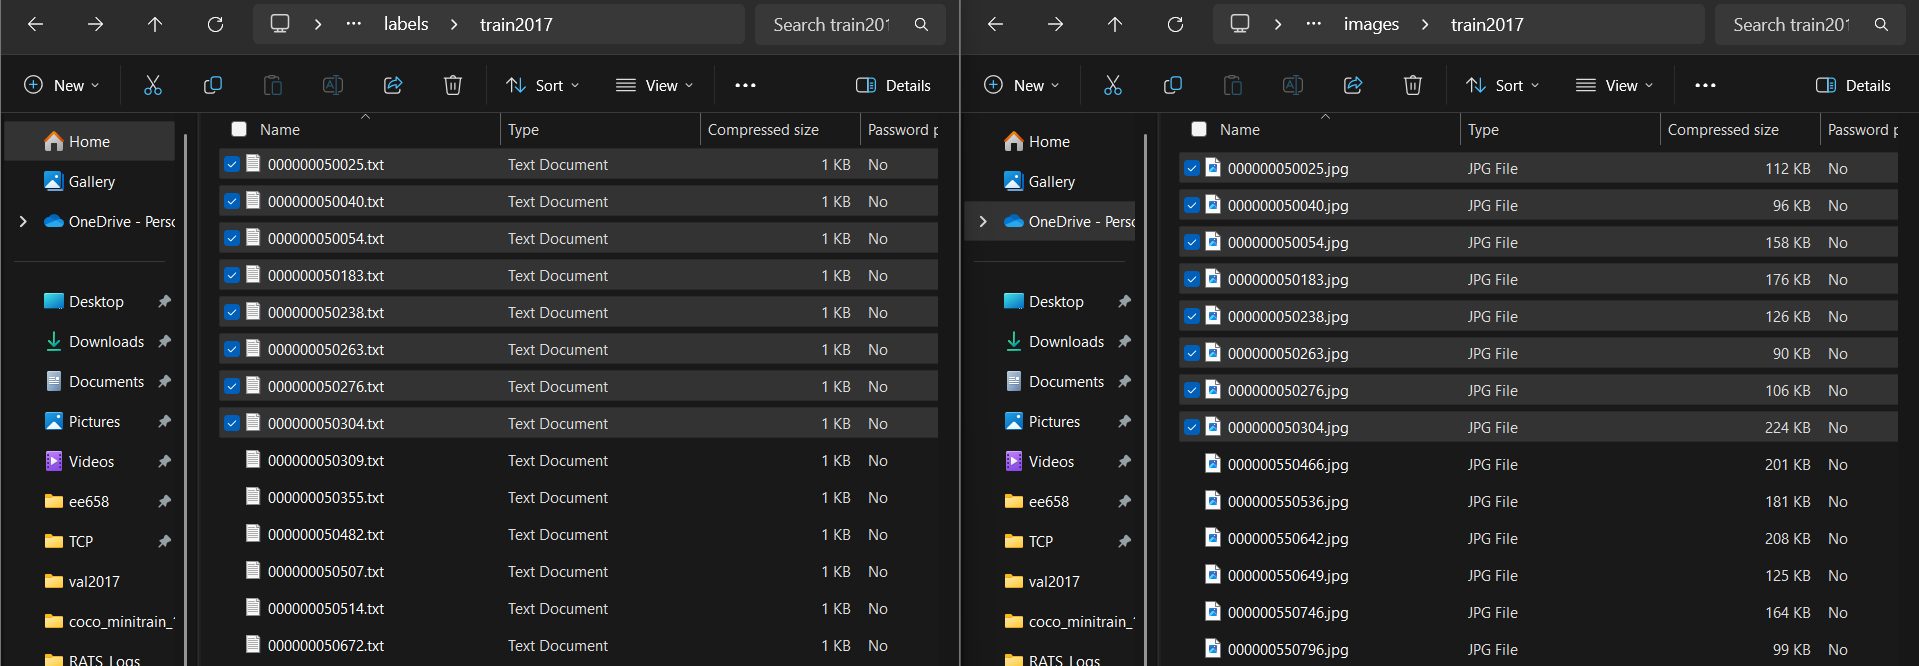

I realized that somewhere in the process of downsizing the 10k dataset to 1k images and labels, I must have messed up somewhere as I noticed at the 790th index, all of a sudden, the images do not match the labels as seen in these file names in the file explorer above. This is probably the most lazy way to go about it but I am going to simply delete all of the images and labels after index 790 and reupload the zip folder to drive.

In [ ]:
!unzip /content/drive/MyDrive/coco_minitrain_790.zip

## 2. Create a Data Pipeline

My train validation split is already near 80/20 (it is 90/10).

## 3. Visualize bounding boxes

### Convert YOLO annotations to x1, y1, x2, y2 style

In [ ]:
# Paths
IMG_DIR = "/content/coco_minitrain_790/images/train2017"
LABEL_DIR = "/content/coco_minitrain_790/labels/train2017"

# Load a few image filenames
image_files = sorted(os.listdir(IMG_DIR))[:5]  # Display the first 5 images

def draw_yolo_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if not os.path.exists(label_path):
        print(f"Label not found for {image_path}")
        return image

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed lines
            cls_id, x_center, y_center, bbox_width, bbox_height = map(float, parts)

            # Convert YOLO (normalized) to pixel coordinates
            x1 = int((x_center - bbox_width / 2) * w)
            y1 = int((y_center - bbox_height / 2) * h)
            x2 = int((x_center + bbox_width / 2) * w)
            y2 = int((y_center + bbox_height / 2) * h)

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
            # Draw class label
            cv2.putText(image, str(int(cls_id)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 1, cv2.LINE_AA)

    return image

### Display Bounding Boxes for 5 images

In [ ]:
# Display a the first 5 images with their bounding boxes
plt.figure(figsize=(15, 10))
for idx, img_name in enumerate(image_files):
    img_path = os.path.join(IMG_DIR, img_name)
    label_name = img_name.replace(".jpg", ".txt")
    label_path = os.path.join(LABEL_DIR, label_name)

    image_with_boxes = draw_yolo_boxes(img_path, label_path)

    plt.subplot(2, 3, idx+1)
    plt.imshow(image_with_boxes)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Implement simple Data Augmentation

In [ ]:
# Color Jitter
from torchvision import transforms

# Load a sample image
img_path = '/content/coco_minitrain_790/images/train2017/000000001089.jpg'
image = Image.open(img_path).convert("RGB")

# Define transformation
transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.8, contrast=0.7, saturation=1)
])

# Apply transform
augmented = transform(image)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(augmented)
ax[1].set_title("Color Jitter")
ax[1].axis('off')

plt.show()

In [ ]:
# Random Flip

# Load a sample image
img_path = '/content/coco_minitrain_790/images/train2017/000000001089.jpg'
image = Image.open(img_path).convert("RGB")

# Define transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0)
])

# Apply transform
augmented = transform(image)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(augmented)
ax[1].set_title("Horizontal Flip")
ax[1].axis('off')

plt.show()

## 5. Summarize challenges and observations

So the first obvious dataset limitation is that the dataset has only 790 images for training. This is very low compared to the full size of the COCO dataset (330,000 images). Also, because of the way I extraced the 790 images (simply took the first 790 images from a mini dataset of 10k images from hugging face) there is most likely a class imbalance as well. These two factors will have great effects on the overall accuracy of each of the four models but I am curious to see how they fare with so little data to train on.

# Q2

## 1. Load a Fast RCNN model

Fast R-CNN relies on an input image **and** pre-generated region proposal boxes to classify objects. The algorithm I used to get these region proposal boxes is the classical Selective Search algorithm, originally used in the paper for Fast R-CNN.

In [ ]:
!pip uninstall -y opencv-python opencv-python-headless opencv-contrib-python
!pip install opencv-contrib-python

In [ ]:
# Load sample image to observe selective search
img_path = "/content/coco_minitrain_790/images/train2017/000000000154.jpg"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Create selective search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()

# Run selective search
rects = ss.process()
print(f"Total region proposals: {len(rects)}")

# Convert first N to proposal boxes [x1, y1, x2, y2]
N = 100
proposals = []
for (x, y, w, h) in rects[:N]:
    proposals.append([x, y, x + w, y + h])
proposals = torch.tensor(proposals, dtype=torch.float32)

# Visualize a few proposal boxes
img_copy = img_rgb.copy()
for (x1, y1, x2, y2) in proposals[:25].int().tolist():
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

plt.figure(figsize=(10, 10))
plt.imshow(img_copy)
plt.title("Top 25 Selective Search Region Proposal Boxes")
plt.axis('off')
plt.show()


Here I am looping through all 790 of my images and using `pickle` to save all the region proposal boxes from selective search to feed into Fast R-CNN. However, it said it would take an hour for my images which make sense since the selective search algorithm is quite bare bones and is computationally intensive.

In [ ]:
def generate_proposals_for_dataset(image_dir, save_path, max_proposals=2000):
    all_proposals = {}  # image_name (no ext) -> list of [x1, y1, x2, y2]

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    image_filenames = sorted(os.listdir(image_dir))
    for filename in tqdm(image_filenames):
        if not filename.endswith(".jpg"):
            continue

        image_path = os.path.join(image_dir, filename)
        img = cv2.imread(image_path)
        if img is None:
            continue

        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        rects = rects[:max_proposals]

        # Convert from [x, y, w, h] to [x1, y1, x2, y2]
        boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])

        all_proposals[filename] = boxes

    # Save proposals
    with open(save_path, "wb") as f:
        pickle.dump(all_proposals, f)

    print(f"Saved proposals to {save_path}")

# Example usage:
generate_proposals_for_dataset(
    image_dir="/content/coco_minitrain_790/images/train2017",
    save_path="/content/train_region_proposals.pkl"
)


To try and shorten the amount of time it takes to generate all of the regions proposals, I am going to cap the number of proposals to 100 for each image.

In [ ]:
def generate_selective_search_proposals(image_dir, save_path=None, max_proposals=100):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    all_proposals = {}

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith((".jpg"))
    ])

    for img_file in tqdm(image_files, desc="Generating Selective Search Proposals"):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Failed to read {img_path}")
            continue

        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()

        # Limit to max_proposals
        proposals = rects[:max_proposals]

        # Save proposals in dictionary
        print(img_file)
        all_proposals[img_file] = proposals

    # Save all proposals only once after loop
    if save_path:
        with open(save_path, "wb") as f:
            pickle.dump(all_proposals, f)

    return all_proposals

Even with limiting the function to only save the top 100 proposals, the estimated runtime was 45 minutes. So, just for Fast R-CNN I am going to
only generate regions proposals for the first 100 images and just train on those first 100 images as the point of this assignment is not accuracy but to compare different architerctures for object detection and classification. I guess this was the entire purpose of faster r-cnn; to dynamically handle region proposals on its own without the help of the computationally intensive selective search algorithm.

In [ ]:
image_dir = "/content/coco_minitrain_790/images/train2017/"
save_path = "/content/region_proposals_train.pkl"

proposals = generate_selective_search_proposals(image_dir, save_path, max_proposals=100)

In [ ]:
def generate_selective_search_proposals_100(image_dir, save_path=None, max_proposals=100, max_images=100):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    all_proposals = {}

    image_files = sorted([
        f for f in os.listdir(image_dir)
        if f.lower().endswith(".jpg")
    ])[:max_images]  # <-- Limit to first N images

    for img_file in tqdm(image_files, desc="Generating Selective Search Proposals"):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Warning: Failed to read {img_path}")
            continue

        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()

        proposals = rects[:max_proposals]
        all_proposals[img_file] = proposals

    if save_path:
        with open(save_path, "wb") as f:
            pickle.dump(all_proposals, f)

    return all_proposals


In [ ]:
image_dir = "/content/coco_minitrain_790/images/train2017/"
save_path = "/content/region_proposals_100_images.pkl"

proposals = generate_selective_search_proposals_100(
    image_dir=image_dir,
    save_path=save_path,
    max_proposals=100,
    max_images=100
)

In [ ]:
# Verify region proposals are as they should be
proposals_pickle = open("/content/region_proposals_100_images.pkl", "rb")
proposal_contents = pickle.load(proposals_pickle)
display(proposal_contents)

This function helps us bypass the default RPN (Region Proposal Network) used by the faster r-cnn architecture and instead use our own pre-generated region proposals as done in Fast R-CNN. It takes in the image, label, **and** the region proposal for that image.

In [ ]:
class FastRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, proposals_dict, transforms=None):
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))
        self.proposals_dict = proposals_dict
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label_path = self.label_paths[idx]
        image_id = os.path.basename(img_path)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = torchvision.transforms.ToTensor()(img)

        # Load YOLO annotations
        h, w = img.shape[:2]
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
        }

        # Get proposals for this image
        proposals = self.proposals_dict[image_id]
        proposals = torch.tensor(proposals, dtype=torch.float32)

        return img_tensor, target, proposals

    def __len__(self):
        return len(self.img_paths)


## 2. Configure the model for training

Since Fast R-CNN is simply the predecessor of Faster R-CNN, we can use torchvision's architecture for Faster R-CNN for Fast R-CNN but making sure to specifically use our pregenerated region proposals.

In [ ]:
class FastRCNNWrapper(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model

    def forward(self, images, targets=None, proposals=None):
        original_image_sizes = [img.shape[-2:] for img in images]
        images, targets = self.model.transform(images, targets)

        features = self.model.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([("0", features)])

        if proposals is None:
            raise ValueError("Proposals must be provided for Fast R-CNN")

        proposals = [p.to(images.tensors.device) for p in proposals]

        detections, detector_losses = self.model.roi_heads(features, proposals, images.image_sizes, targets)
        detections = self.model.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        if self.training:
            return detector_losses
        return detections


## 3. Train the model on the prepared dataset

Create new folders for the 100 size image and labels folders since regions proposals was only done for the first 100 images due to high computing time for selective search algorithm

In [ ]:
# New directories
new_img_dir = '/content/coco_minitrain_790/images/train100/'
new_label_dir = '/content/coco_minitrain_790/labels/train100/'

# Create the new directories if they don't exist
os.makedirs(new_img_dir, exist_ok=True)
os.makedirs(new_label_dir, exist_ok=True)

In [ ]:
img_dir = "/content/coco_minitrain_790/images/train2017/"
label_dir = "/content/coco_minitrain_790/labels/train2017/"

# Get the first 100 image paths
image_paths = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')])[:100]

# Copy the selected images and labels to the new directories
for img_name in image_paths:
    # Define paths
    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

    # Copy image
    new_img_path = os.path.join(new_img_dir, img_name)
    shutil.copy(img_path, new_img_path)

    # Copy corresponding label
    new_label_path = os.path.join(new_label_dir, img_name.replace('.jpg', '.txt'))
    shutil.copy(label_path, new_label_path)

print("First 100 images and labels have been copied.")

In [ ]:
# Image and Labels Paths
img_dir = '/content/coco_minitrain_790/images/train100'
label_dir = '/content/coco_minitrain_790/labels/train100'

# Load the pickle file
with open("/content/region_proposals_100_images.pkl", "rb") as f:
    proposals_dict = pickle.load(f)

# Convert region proposals into tensors since the forward(method) expects tensors
for image_id, proposals in proposals_dict.items():
    # Convert proposals (assumed to be a list or array) to a PyTorch tensor
    proposals_tensor = torch.tensor(proposals, dtype=torch.float32)
    proposals_dict[image_id] = proposals_tensor

# ---- Dataset ----
dataset = FastRCNNDataset(
    img_dir=img_dir,
    label_dir=label_dir,
    proposals_dict=proposals_dict,
    transforms=T.ToTensor()
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Although using Faster R-CNN Model, we are bypassing the RPN to use our pre generated region proposals
base_model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = base_model.roi_heads.box_predictor.cls_score.in_features
num_classes = 81  # COCO (80 + background)
base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = FastRCNNWrapper(base_model)

# Setup for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets, proposals in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        proposals = [p.to(device) for p in proposals]

        loss_dict = model(images, targets=targets, proposals=proposals)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(dataloader)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")

print("Training complete!")

In [ ]:
# torchmetrics library makes getting mAP value easier
!pip install torchmetrics

from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
# Run model on validation dataset and find average mAP value

img_dir = '/content/coco_minitrain_790/images/val2017'
label_dir = '/content/coco_minitrain_790/labels/val2017'

# Initialize the mAP evaluator
map_metric = MeanAveragePrecision()
model.eval()

# Collect all image and label paths
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

for img_path, label_path in zip(img_paths, label_paths):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    img_pil = Image.fromarray(img_rgb)
    img_tensor = transforms.ToTensor()(img_pil).to(device)

    # Load ground truth annotations (YOLO format)
    boxes = []
    labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = (cx - bw / 2) * w
            y1 = (cy - bh / 2) * h
            x2 = (cx + bw / 2) * w
            y2 = (cy + bh / 2) * h
            boxes.append([x1, y1, x2, y2])
            labels.append(int(cls))

    target = {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }

    # Inference
    model = base_model
    model.eval()
    model.to(device)
    with torch.no_grad():
        outputs = model([img_tensor])

    preds = {
        "boxes": outputs[0]["boxes"].cpu(),
        "scores": outputs[0]["scores"].cpu(),
        "labels": outputs[0]["labels"].cpu()
    }

    # Update mAP metric with predictions and ground truth
    map_metric.update([preds], [target])

# Compute final mAP
final_map = map_metric.compute()
print("Validation mAP:", final_map)

## 4. Visualize predictions

In [ ]:
from torchvision.ops import box_iou

def visualize_predictions(model, img_dir, label_dir, device, num_images=5, iou_threshold=0.5):
    # Randomly select images
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))
    selected_indices = random.sample(range(len(img_paths)), num_images)

    for idx in selected_indices:
        img_path = img_paths[idx]
        label_path = label_paths[idx]
        image_id = os.path.basename(img_path)

        # Load the image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load YOLO annotations (ground truth)
        h, w = img.shape[:2]
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))

        # Convert ground truth boxes to tensor
        gt_boxes = torch.tensor(boxes, dtype=torch.float32)
        gt_labels = torch.tensor(labels, dtype=torch.int64)

        # Move ground truth boxes and labels to CPU
        gt_boxes = gt_boxes.cpu()  # Move to CPU
        gt_labels = gt_labels.cpu()  # Move to CPU

        # Prepare the image for model inference
        img_pil = Image.fromarray(img_rgb)
        transform = transforms.ToTensor()
        img_tensor = transform(img_pil).to(device)

        # Make predictions (pass the image as a list)
        model = base_model
        model.eval()
        model.to(device)
        with torch.no_grad():
            predictions = model([img_tensor])  # Pass as a list of tensors

        # Extract predicted bounding boxes, labels, and scores
        pred_boxes = predictions[0]['boxes']
        pred_labels = predictions[0]['labels']
        pred_scores = predictions[0]['scores']

        # Move predicted boxes, labels, and scores to CPU
        pred_boxes = pred_boxes.cpu()  # Move to CPU
        pred_labels = pred_labels.cpu()  # Move to CPU
        pred_scores = pred_scores.cpu()  # Move to CPU

        # Filter predictions based on IoU threshold
        pred_boxes, pred_labels, pred_scores = filter_predictions_by_iou(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold)

        # Plot the image and the predictions
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(img_rgb)

        # Plot ground truth boxes (blue)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{label.item()}', color='blue', fontsize=12)


        # Plot predicted boxes (red)
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{label.item()}:{score:.2f}', color='red', fontsize=12)

        # Add title
        ax.set_title(f"Image {image_id}", fontsize=16)
        plt.show()

# Helper function to filter predictions by IoU threshold
def filter_predictions_by_iou(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    iou = box_iou(pred_boxes, gt_boxes)
    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for i in range(len(pred_scores)):
        max_iou, max_idx = torch.max(iou[i], dim=0)
        if max_iou > iou_threshold:
            filtered_boxes.append(pred_boxes[i])
            filtered_labels.append(pred_labels[i])
            filtered_scores.append(pred_scores[i])

    return filtered_boxes, filtered_labels, filtered_scores

# Example Usage
img_dir = '/content/coco_minitrain_790/images/val2017/'
label_dir = '/content/coco_minitrain_790/labels/val2017/'

# Load the trained model and put it on the correct device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FastRCNNWrapper(base_model).to(device)

# Call the visualization function
visualize_predictions(model, img_dir, label_dir, device, num_images=3)

## 5. Evaluate performance

mAP on the validation dataset:

**Validation mAP: 0.0046** (Extremely low, but this is expected when I only trained on a measly 100 images and the full COCO Dataset consists of 330,000 images)

Inference Speed = 3 minutes = 180 seconds / 100 images = 1.8 sec/image

**Inference Speed: 1.8 seconds per image**

**Memory Usage: 11.5 GB GPU RAM**

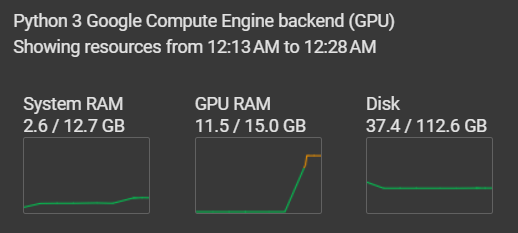

**Fast R-CNN Strengths:**
Fast R-CNN's major improvement on R-CNN was to use a single CNN pass for the entire image intead of extracting features from each singular region proposal as is done in normal R-CNN. This means that the convolutional layers are shared across all of the region proposals in Fast R-CNN. This improvement is the biggest reason as to why the inference time is quicker and is called Fast R-CNN.


**Fast R-CNN Weaknesses:**
As experienced very closely here, a big weakness is that Fast R-CNN needs pre-generated region proposals (like from selective search for example) which is very computationally expensive to generate and takes a lot of time. This also means that if the region proposals, generated by the selected algorithm, are of poor quality, then Fast R-CNN will produce poor results. Faster R-CNN aims to solve this however seen next.


# Q3

## 1. Load a Faster RCNN model

In [ ]:
# Create Dataset Class that gets all of the images .jpg and labels .txt files from where we stored them locally
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        w, h = image.size  # Get image width and height

        # Load YOLO-style labels
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        boxes = []
        labels = []

        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, cx, cy, bw, bh = map(float, line.strip().split())

                # Convert YOLO format to xmin, ymin, xmax, ymax
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))  # Use the class index

        # Convert boxes and labels to tensors
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.empty((0, 4), dtype=torch.float32)  # Empty tensor for boxes
            labels = torch.empty(0, dtype=torch.int64)  # Empty tensor for labels

        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, target


In [ ]:
# Define the paths for images and labels
image_dir = '/content/coco_minitrain_790/images/train100'
label_dir = '/content/coco_minitrain_790/labels/train100'

# Define a transformation since PyTorch models require tensors
transform = T.Compose([
    T.ToTensor(),
])

# Initialize the dataset
train_dataset = CustomCocoDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    transform=T.ToTensor()
)

# Initialize dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 81  # COCO (80 + background)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## 2. Train the Faster RCNN model

After about 22 minutes of trying to train the model, not even one epoch had finished. This was because I was using CPU only as I have exhausted all my resources for the GPU trying to get Fast R-CNN to work. I then tried training on only 100 images instead of the full 790 images. It still took way too long. So, I just ended up buying the $9.99 subscription to colab pro for more gpu compute. It still took 5 minutes just for one epoch so I am still going to turn down the images to just 100 but at least now I can use the T4 GPU compute unit.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0001) # Trying adam optimizer for faster convergence

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimize
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item()}")


In [ ]:
# Using T4 GPU and only 100 images for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0001) # Trying adam optimizer for faster convergence

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimize
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item()}")


## 3. Validate the model

In [ ]:
# Run model on validation dataset and find average mAP value

img_dir = '/content/coco_minitrain_790/images/val2017'
label_dir = '/content/coco_minitrain_790/labels/val2017'

# Initialize the mAP evaluator
map_metric = MeanAveragePrecision()
model.eval()

# Collect all image and label paths
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

for img_path, label_path in zip(img_paths, label_paths):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    img_pil = Image.fromarray(img_rgb)
    img_tensor = T.ToTensor()(img_pil).to(device)

    # Load ground truth annotations (YOLO format)
    boxes = []
    labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = (cx - bw / 2) * w
            y1 = (cy - bh / 2) * h
            x2 = (cx + bw / 2) * w
            y2 = (cy + bh / 2) * h
            boxes.append([x1, y1, x2, y2])
            labels.append(int(cls))

    target = {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }

    # Inference
    model.to(device)
    with torch.no_grad():
        outputs = model([img_tensor])

    preds = {
        "boxes": outputs[0]["boxes"].cpu(),
        "scores": outputs[0]["scores"].cpu(),
        "labels": outputs[0]["labels"].cpu()
    }

    # Update mAP metric with predictions and ground truth
    map_metric.update([preds], [target])

# Compute final mAP
final_map = map_metric.compute()
print("Validation mAP:", final_map)

Again, these mAP values are just abysmal and that is definitely due to only training for 100 images but the times are just taking way too long (~ 50 minutes to an hour even for **only** 790 images) so I will focus on understanding the strengths, weaknesses, and differences between the two object detection models rather than getting good results.

## 4. Visualize predictions

In [ ]:
from torchvision.ops import box_iou

def visualize_predictions(model, img_dir, label_dir, device, num_images=5, iou_threshold=0.5):
    # Randomly select images
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))
    selected_indices = random.sample(range(len(img_paths)), num_images)

    for idx in selected_indices:
        img_path = img_paths[idx]
        label_path = label_paths[idx]
        image_id = os.path.basename(img_path)

        # Load the image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load YOLO annotations (ground truth)
        h, w = img.shape[:2]
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                x2 = (cx + bw / 2) * w
                y2 = (cy + bh / 2) * h
                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls))

        # Convert ground truth boxes to tensor
        gt_boxes = torch.tensor(boxes, dtype=torch.float32)
        gt_labels = torch.tensor(labels, dtype=torch.int64)

        # Move ground truth boxes and labels to CPU
        gt_boxes = gt_boxes.cpu()  # Move to CPU
        gt_labels = gt_labels.cpu()  # Move to CPU

        # Prepare the image for model inference
        img_pil = Image.fromarray(img_rgb)
        transform = T.ToTensor()
        img_tensor = transform(img_pil).to(device)

        # Make predictions (pass the image as a list)
        model.eval()
        model.to(device)
        with torch.no_grad():
            predictions = model([img_tensor])  # Pass as a list of tensors

        # Extract predicted bounding boxes, labels, and scores
        pred_boxes = predictions[0]['boxes']
        pred_labels = predictions[0]['labels']
        pred_scores = predictions[0]['scores']

        # Move predicted boxes, labels, and scores to CPU
        pred_boxes = pred_boxes.cpu()  # Move to CPU
        pred_labels = pred_labels.cpu()  # Move to CPU
        pred_scores = pred_scores.cpu()  # Move to CPU

        # Filter predictions based on IoU threshold
        pred_boxes, pred_labels, pred_scores = filter_predictions_by_iou(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold)

        # Plot the image and the predictions
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(img_rgb)

        # Plot ground truth boxes (blue)
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{label.item()}', color='blue', fontsize=12)


        # Plot predicted boxes (red)
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{label.item()}:{score:.2f}', color='red', fontsize=12)

        # Add title
        ax.set_title(f"Image {image_id}", fontsize=16)
        plt.show()

# Helper function to filter predictions by IoU threshold
def filter_predictions_by_iou(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_threshold=0.5):
    iou = box_iou(pred_boxes, gt_boxes)
    filtered_boxes = []
    filtered_labels = []
    filtered_scores = []

    for i in range(len(pred_scores)):
        max_iou, max_idx = torch.max(iou[i], dim=0)
        if max_iou > iou_threshold:
            filtered_boxes.append(pred_boxes[i])
            filtered_labels.append(pred_labels[i])
            filtered_scores.append(pred_scores[i])

    return filtered_boxes, filtered_labels, filtered_scores

# Example Usage
img_dir = '/content/coco_minitrain_790/images/val2017/'
label_dir = '/content/coco_minitrain_790/labels/val2017/'

# Load the trained model and put it on the correct device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Call the visualization function
visualize_predictions(model, img_dir, label_dir, device, num_images=3)

## 5. Compare Fast RCNN vs. Faster RCNN

```
   Fast R-CNN  | Faster R-CNN
---------------|-------------
    0.0046     |   1.2405e-5    mAP
    1.8        |   1.2          inference speed (seconds per image)
    11.6       |   14.7 gB      memory on GPU compute unit
```

So the first thing is that the mAP value for Fast R-CNN was slightly higher than for Faster R-CNN. I think this is because the Fast R-CNN took more time which allowed it to make better predictions compared to Faster R-CNN which sacrificed accuracy for quicker training times. However, this conclusion might not be sound since I trained on only **100** images for both models.

As for the reason Faster R-CNN runs faster than Fast R-CNN is that Faster R-CNN takes it a step further by no longer relying on external region proposals like from selective search. It instead has something called an RPN (region proposal network) that is directly integrated into the model. Since the RPN is a part of the architecture, even the process of generating region proposals is trainable and thus becomes more efficient. Before, with selective search, there was no way to optimize how the algorithm generated region proposals so it would take a very long time.

Because Faster R-CNN sacrificed accuracy for quicker runtimes, the mAP value was slightly lower. But the training times were an entire minute quicker with its RPN. Also, by looking visually at the boundary boxes, it seems that Faster R-CNN did a better job of the location and size of the boxes but a worse job at classifying those boxes or objects when compared to Fast R-CNN.

# Q4

## 1. Load and train YOLOv5

In [ ]:
# Clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Kept getting an error of out of memory when using the T4 GPU with 16GB ram and I tried changing the batch size with no luck. I moved to the nvidia A100 GPU and was successful.

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/coco_minitrain_790/coco2017.yaml --weights yolov5s.pt --name yolo_coco_train

## 2. Evaluate and visualize

In [ ]:
from IPython.display import Image, display
display(Image(filename='runs/train/yolo_coco_train/results.png'))

In [ ]:
!python detect.py --weights runs/train/yolo_coco_train/weights/best.pt --img 640 --source /content/coco_minitrain_790/images/train2017

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/yolov5/runs/detect/exp/000000005099.jpg')
cv2_imshow(image)
image = cv2.imread('/content/yolov5/runs/detect/exp/000000005303.jpg')
cv2_imshow(image)
image = cv2.imread('/content/yolov5/runs/detect/exp/000000008593.jpg')
cv2_imshow(image)

Although in my case the mAP was significantly higher for YOLOv5 than it was for F-RCNN or FR-RCNN, what occurs in most cases, is that the YOLOv5 model can indeed train quicker than RCNN family since it has a single stage approach for predicting bounding boxes **and** finding class probabilities compared to the RCNN family first having to do region proposal and then object classification (more like two stage). However, this same single stage approach (single fully connected layer really) that helps runtimes also worsens the accuracy of the bounding boxes because the method which it uses to create region proprosals (what everything relies on) is less accurate which it needs to be, so that YOLOv5 is as quick as it is.

# Q5

## 1. Train a modern YOLO variant

In [ ]:
# Make sure ultralytics package installed already
!pip install ultralytics

In [ ]:
# Everything is already setup for YOLO models as I just previously ran a YOLOv5 model
from ultralytics import YOLO

model = YOLO('yolov8s.pt')  # or yolov8m.pt, yolov8l.pt, etc.
model.train(
    data='/content/coco_minitrain_790/coco2017.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8_coco_train'
)


In [ ]:
# Visualize metrics for YOLOv8
from IPython.display import Image, display
display(Image(filename='/content/runs/detect/yolov8_coco_train/results.png'))

In [ ]:
# Run the model for first three images in the validation dataset
from glob import glob
model = YOLO('/content/runs/detect/yolov8_coco_train/weights/best.pt')

validation_img_dir = '/content/coco_minitrain_790/images/val2017'
val_images = sorted(glob(os.path.join(validation_img_dir, '*.jpg')))[:3]  # get 3 images

# Run prediction
results = model.predict(val_images, save=False, conf=0.25)

# Plot the 3 images with their labels
for i, r in enumerate(results):
    im_array = r.plot()  # annotated image as numpy array
    plt.figure(figsize=(10, 6))
    plt.imshow(im_array)
    plt.axis('off')
    plt.title(f'Prediction {i+1}')
    plt.show()

YOLOv8 proved to be a bit better as its mAP value was ~0.44 compared to YOLOv5 which had an mAP value of ~0.33. From what I understand, if there was one major difference that could be attributed to this increase in the mAP value between v8 and v5 it would be the introduction of what is called ViTs or Vision Transformers. YOLOv8 uses both CNNs and ViTs together to get the benefits from both. Specifically, ViTs are much better at detecting objects that are in very complex or cluttered scenes than CNNs. This issue of cluttered images was one of the big drawbacks with YOLOv5 so with the use of ViTs, YOLOv8 is better capable of noisy images.

To go in more depth, Vision Transformers (ViT) are the image equivalent of the popular use of transformers in Natural Language Processing (NLP). They do inherit some concepts from the transformers architecture for NLP but they are specially designed to handle image data for computer vision.

Also, no changes were made in hyperparameters or anchors.